# Introduction

In this snippet, we will explore something that does not really fall into the realm of traditional actuarial problems, but still extremely useful nonetheless. This article will go through the process of text classification. <br><br> The dataset used can be found at <br>
https://www.kaggle.com/sebastienverpile/consumercomplaintsdata <br>
https://catalog.data.gov/dataset/consumer-complaint-database <br>
and consists of finance related complaints that a company has recieved from its customers. <br><br> This problem will be split into 2 parts; transforming text data into usable inputs, and performing classification with those inputs.

The packages that we will be using are listed below. <br>
Pandas and Numpy for general data manipulation <br>
Matplotlib and Seaborn for general data visualisation <br>
Sci-kit learn packages for both feature extraction and classification model

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Part 0 - Importing and Cleaning Data

Since we are trying to predict category of products based on the narrative of the complaints recieved, we can ignore the rest of the columns for the purpose of this exercise and only look at the single feature and target columns. We will also get rid of null entries as they will not be of any use to us.

In [2]:
df = pd.read_csv('Consumer_Complaints.csv')
df = df.loc[(df['Consumer complaint narrative'].notnull()), ['Consumer complaint narrative', 'Product']] \
           .reset_index() \
           .drop('index', axis = 1)
df = df[(np.logical_not(df.Product.str.contains(','))) & (df.Product != 'Credit card or prepaid card')]
df.columns = ['description', 'target']

df.head()

,description,target
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


Next, we will assign each target variable an integer value instead of using the string, which allows our models to be able to read our responses. We can do this using a variety of methods, but here we will be using sklearn's labelencoder function.

In [3]:
encoder = LabelEncoder()
encoder.fit(df.target)
df = df.assign(encoded_response = lambda x: encoder.transform(x.target))
df[['target', 'encoded_response']].drop_duplicates() \
                                                            .set_index('target') \
                                                            .sort_values('encoded_response', ascending = True)

,encoded_response
target,
Bank account or service,0
Checking or savings account,1
Consumer Loan,2
Credit card,3
Credit reporting,4
Debt collection,5
Money transfers,6
Mortgage,7
Other financial service,8


We can see from the above output that our resulting dataset contains 14 unique categories which we will try to classify complaints into by training our model to "understand" the narrative.

Next, we will split our dataset for training and validation purposes. Regardless of technique used, train test splits are always considered to be good practice and is extremely helpful to prevent over-fitting of the model.

In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.description, 
                                                                                      df.encoded_response, 
                                                                                      test_size = 0.2, 
                                                                                      random_state = 123)

# Part 1 - Text to features

Although there are many examples of machine learning models that make use of a variety of inputs such as; images ect. we must understand that ultimately, whatever input chosen must be converted into numerical features in order to be "understood" by the model. That being said, images are made up of pixels, which can generally be represented by a integer triplet (x, y, z) indicating the intensity of RGB respectively. <br> In this section, we will find a meaningful way to represent our text data as numerical features. This is also known as feature extraction.

## Bag Of Words Model

One way of transforming a document full of text into numerical features is using the BOW (Bag Of Words) model. Put simply, all it does is assign each word (or token) an ID number, with its respective count. For example, if we have a document string <br>
"This is a cat. That is a dog."
<br>
The BOW representation would simply be {"This": 1, "is": 2, "a": 2, "cat" : 1, "That" : 1, "dog" : 1}
<br>
From the example above we can see that the BOW model just represents a document as its individual component words with its respective count attached to it. Notice that the document shown above is clearly about a cat and a dog. However, our BOW model shows that the most frequent words present in the document is "is" and "a". This is where the importance of data preprocessing is more obvious compared to other machine learning techniques. These common words are also known as "stop words" and are usually taken out of the BOW model to prevent overpowering the words that have actual importance. There are many different little tricks and techniques for choosing the most suitable bag of words to represent your documents and most can be implemented simply through a line (or two) of code using [regular expressions](https://docs.python.org/2/library/re.html).<br>
How does this link to having a numerical matrix as an input? Well, imagine that we have a thousand text documents. We would choose (or use all of) the set of unique words present in that 1000 documents and give word a unique ID number, and make the our columns for the input matrix. For example, if we had chosen 15,000 unique tokens from the 1000 documents as our "dictionary", our input matrix would then have 15,000 columns! Each individual document will then represent a row in the (now extremely wide) matrix filled mostly with zeros, except for the columns corresponding to words found in that particular document, which will contain the count of that word. This technique is also commonly known as count vectorizing. <br>
In the follow example however, we will be using a more robust model compared to count vectorizing called (TF-IDF) Term Frequency - Inverse Document Frequency, and it is defined as:

$w_{i,j} = tf_{i,j} * log(\dfrac{N}{df_i})$ 
<br><br>
$w_{i,j}$ = Weight for word(i) in document(j) <br>
$tf_{i,j}$ = Count of word(i) in document(j) <br>
$N$ = Total number of documents <br>
$df_i$ = How many documents word(i) appears in<br><br>

We can see that, the first term of the TF-IDF model is just the count of the word in the document as before. The magic happens in the second term where the model imposes an additional condition for a particular word to be deemed "important". Just as an example, if the word "bank" appears in every single document, it wouldn't be of much use in differentiating the documents, and the second term of the TF-IDF model expresses this by reducing the whole weight down to 0.

There are a variety of packages that help to automate the vectorizing process but we have chosen to use the Sci-kit learn API due to its easy of usage and interpretability. Here, we instantiate a TFIDF model, with a few note-worthy details: <br>
1) Sublinear_tf uses a logarithmic form of frequency as 20 occurrences of a word probably does not imply 20 times of importance <br>
2) The model will ignore words that appear in less than 5 documents, as well as more than 70% of the total documents <br>
3) Normalization is set to l2 so that all vectors are scaled to have a magnitude of 1 (The equivalent of standardizing your features) <br>
4) There is a layer of preprocessing to remove numerical characters and symbols within the documents through the use of a regular expression

In [5]:
tfidf_vectorizer = TfidfVectorizer(sublinear_tf = True, 
                                                           stop_words = 'english',
                                                           min_df = 5,
                                                           max_df = 0.7,
                                                           norm = 'l2',
                                                           #ngram_range = (1, 2),
                                                           token_pattern = r'\b[^_\d\W]+\b')

We then use the model to fit our original text data, and convert all that sweet text information into something numerical!

In [6]:
tfidf_train = tfidf_vectorizer.fit_transform(x_train.values)
tfidf_test = tfidf_vectorizer.transform(x_test.values)

In [7]:
print(len(tfidf_vectorizer.get_feature_names()))

19344


We can see that our resulting dictionary consists of 19,344 different unqiue words!

In [8]:
tfidf_df = pd.DataFrame(tfidf_train.A, 
                                            columns = tfidf_vectorizer.get_feature_names())

In [9]:
tfidf_df.head()

,aa,aaa,aaddress,aadvantage,aafes,aag,aand,aargon,aarp,ab,...,zilch,zions,zip,zipcode,zombie,zone,zoned,zones,zoning,zwicker
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As mentioned above, the 19,344 words chosen to be in our "dictionary" become the columns of our input matrix and as you can probably guess, since we have so many columns and each row only consists of words within 1 document, the resulting matrix will be extremely sparse! (Consisting mostly of zeros) <br>
Now that we have extracted some numerical features from our dataset, it is time to use them to train a classifier!

# Part 2 - Classification Model

In this example, we have chosen to use a basic [logistic regression model](http://www.appstate.edu/~whiteheadjc/service/logit/intro.htm) to classify the documents due to tractability and convention. However, more complex models such as neural networks, decision trees, naive bayesian classifiers or other relevant models can also be used to do the following classification.

Firstly, we instantiate a logistic regression classifier from the sklearn package and proceed to fit our vectorized matrix and our encoded training labels.

In [10]:
lr_classifier = LogisticRegression()
lr_classifier.fit(tfidf_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
pred = lr_classifier.predict(tfidf_test)

In [12]:
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8521861933375793


By running the model on the validation set, we can see that we attained some pretty decent predictive power with an overall accuracy of 85.2%. We can drill down into this result by evaluating the [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology).

In [13]:
cm = metrics.confusion_matrix(y_test, pred)

Text(0.5,1,'Accuracy Score: 0.8521861933375793')

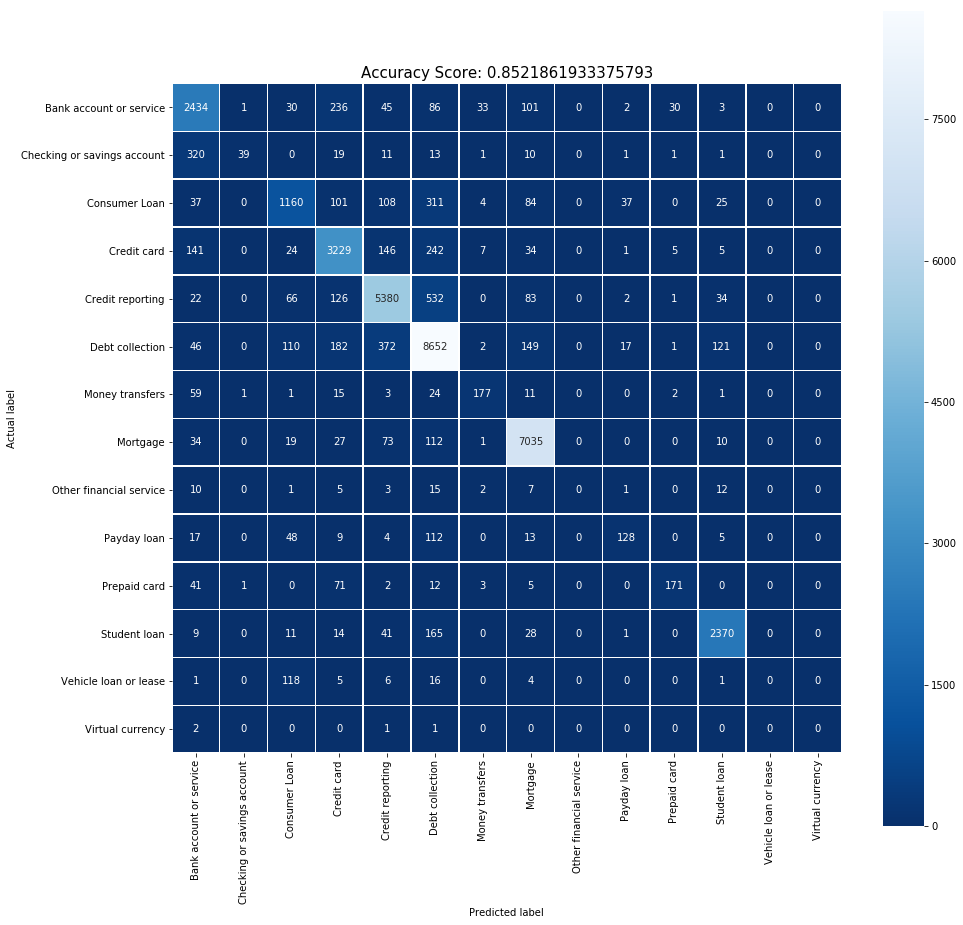

In [14]:
plt.figure(figsize = (15,15))
sns.heatmap(cm, 
                        annot = True, 
                        fmt = ".0f", 
                        linewidths = 0.5, 
                        square = True, 
                        cmap = 'Blues_r', 
                        xticklabels = encoder.classes_,
                        yticklabels = encoder.classes_)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

One of the obvious details we can observe from the matrix is that "Other financial service", "Vehicle loan or lease" and "Virtual currency" categories had no correct predictions. We must note however, that the number of rows for each of those categories were relatively insignificant compared to the others and the model could very well have treated those instances as errors instead of a distinct category.

In [50]:
def report2dict(cr):
    '''Function purely for asthetic formatting purposes, can be ignored'''
    
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    measures = tmp[0]
    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
            
    return D_class_data


results = report2dict(metrics.classification_report(y_test, pred, target_names = encoder.classes_))
pd.DataFrame(results).transpose()

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,f1-score,precision,recall,support
Bank account or service,0.79,0.77,0.81,3001.0
Checking or savings account,0.17,0.93,0.09,416.0
Consumer Loan,0.67,0.73,0.62,1867.0
Credit card,0.82,0.80,0.84,3834.0
Credit reporting,0.86,0.87,0.86,6246.0
Debt collection,0.87,0.84,0.90,9652.0
Money transfers,0.68,0.77,0.60,294.0
Mortgage,0.95,0.93,0.96,7311.0
Other financial service,0.00,0.00,0.00,56.0
Payday loan,0.49,0.67,0.38,336.0


This bias however, can be corrected by techniques such as [over and undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis). Categories with more data points generally did better and errors observed in classification seem to be pretty reasonable due to overlap in categories. (For example, 320 descriptions that were supposed to be "Checking and savings account" related were wrongly classified as "Bank account and service", which presumably contains overlapping ideas.)

As mentioned above, data preprocessing is an extremely important step when it comes to NLP problems and the "garbage-in, garbage-out" property can be very prevalent compared to other machine learning techniques. Also note that, in this problem that there are existing labels in the dataset, and we could have just as easily used any other supervised learning techniques to classify the documents. If however, no labels are available, we would then have to turn towards unsupervised learning algorithms such as SVM, K-means or LDA to try and cluster the documents into sensible categories.

# Afterward

We have essentially just taught the computer how to "understand" a small selected group of documents in a very human way, which is just amazing! So, you might ask, how does this apply to actuarial work? <br>
Imagine having access to all the historical claim narratives within your company's database. What are some possible projects or analysis that you think could value add to the company now that you know how to model text? Could you maybe come up with a classifier using techniques above coupled with some clustering analysis techniques such as K-Means to categorize the claims if the legacy system does not have this feature? What about doing some sentiment analysis on the claim narratives to get the general satisfaction level of customers and to help pinpoint the strengths and weaknesses of the insurer's current claims handling process? <br>
Do not be mistaken though, the possibilites are not constrained to the claims management section of the insurance value chain. Other examples include chatbots and recommendation systems as distribution channels, and fraud detection with text analysis. The possibilities are ever-growing, technology ever-improving and it is up to the actuarial profession to keep up with the trends in order to continue adding value to the industry.


# Additional Resources

[TF-IDF Model](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) <br>
[Python Regular Expressions (REGEX)](https://www.tutorialspoint.com/python/python_reg_expressions.htm) <br>
[Logistic Regression](http://www.appstate.edu/~whiteheadjc/service/logit/intro.htm) <br>
[Confusion Matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)